In [6]:
# Neuro
import mne
import mne_bids

# ML/Data
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops


# Tools
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib


mne.set_log_level(False)


In [7]:

def decod(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-3, 8, 10)))
    cv = KFold(5, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    R = np.zeros(n_times)
    for t in range(n_times):
        print(".", end="")
        y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        R[t] = correlate(y, y_pred)
    return R


# Function to correlate
def correlate(X, Y):
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X**2).sum(0) ** 0.5
    SY2 = (Y**2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    return SXY / (SX2 * SY2)


# Utils
def match_list(A, B, on_replace="delete"):
    """Match two lists of different sizes and return corresponding indice
    Parameters
    ----------
    A: list | array, shape (n,)
        The values of the first list
    B: list | array: shape (m, )
        The values of the second list
    Returns
    -------
    A_idx : array
        The indices of the A list that match those of the B
    B_idx : array
        The indices of the B list that match those of the A
    """

    if not isinstance(A, str):
        unique = np.unique(np.r_[A, B])
        label_encoder = dict((k, v) for v, k in enumerate(unique))

        def int_to_unicode(array: np.ndarray) -> str:
            return "".join([str(chr(label_encoder[ii])) for ii in array])

        A = int_to_unicode(A)
        B = int_to_unicode(B)

    changes = editops(A, B)
    B_sel = np.arange(len(B)).astype(float)
    A_sel = np.arange(len(A)).astype(float)
    for type_, val_a, val_b in changes:
        if type_ == "insert":
            B_sel[val_b] = np.nan
        elif type_ == "delete":
            A_sel[val_a] = np.nan
        elif on_replace == "delete":
            # print('delete replace')
            A_sel[val_a] = np.nan
            B_sel[val_b] = np.nan
        elif on_replace == "keep":
            # print('keep replace')
            pass
        else:
            raise NotImplementedError
    B_sel = B_sel[np.where(~np.isnan(B_sel))]
    A_sel = A_sel[np.where(~np.isnan(A_sel))]
    assert len(B_sel) == len(A_sel)
    return A_sel.astype(int), B_sel.astype(int)


def get_subjects():
    subjects = pd.read_csv(str(PATHS.data) + "/participants.tsv", sep="\t")
    subjects = subjects.participant_id.apply(lambda x: x.split("-")[1]).values
    # subjects = np.delete(subjects, subjects.shape[0]-1)
    # Let's sort this array before outputting it!
    int_subjects = np.sort([int(subj) for subj in subjects])
    subjects = [str(subj) for subj in int_subjects]

    return subjects



In [8]:

class PATHS:
    path_file = Path("./data_path.txt")
    if not path_file.exists():
        data = Path(input("data_path?"))
        # assert data.exists()
        with open(path_file, "w") as f:
            f.write(str(data) + "\n")
    with open(path_file, "r") as f:
        data = Path(f.readlines()[0].strip("\n"))
        print(f"File opened: {data}")
        if str(data).__contains__("final"):
            print("Processed data (Maxwell filtered) used")
        if str(data).__contains__("BIDS"):
            print("Raw data (no filtering) used")
    # assert data.exists()


TASK = "rest"
# To simplify for the time being
# To run on the Neurospin workstation
PATHS.data = Path("/home/co/workspace_LPP/data/MEG/LPP/LPP_bids")

File opened: /home/is153802/code/phoneme_decoding/stimuli


In [9]:
bids_path = mne_bids.BIDSPath(
            subject="220628",
            session="01",
            task=TASK,
            datatype="meg",
            root=PATHS.data,
            run='01',
        )

In [10]:
raw = mne_bids.read_raw_bids(bids_path)
raw.pick_types(meg=True, stim=True)
raw.load_data()
raw = raw.filter(0.5, 20)

event_file = PATHS.data / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()
# read events
meta = pd.read_csv(event_file, sep="\t")
events = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

phonemes = meta[meta.trial_type.str.contains('phoneme')]
words = meta[meta.trial_type.str.contains('word')]

/tmp/ipykernel_40962/2074814851.py:1: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_40962/2074814851.py:1: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [11]:
words

,onset,duration,trial_type
0,3.05,0.37,"{'kind': 'word', 'word': 'lorsque'}"
1,3.42,0.02,"{'kind': 'word', 'word': 'j'}"
2,3.53,0.23,"{'kind': 'word', 'word': 'avais'}"
3,3.93,0.25,"{'kind': 'word', 'word': 'six'}"
4,4.18,0.18,"{'kind': 'word', 'word': 'ans'}"
...,...,...,...
1627,609.51,0.14,"{'kind': 'word', 'word': 'peut'}"
1628,609.65,0.22,"{'kind': 'word', 'word': 'pas'}"
1629,609.87,0.17,"{'kind': 'word', 'word': 'aller'}"
1630,610.04,0.16,"{'kind': 'word', 'word': 'bien'}"


In [12]:
subject = '220628'
run_id = '01'

# match events and metadata
word_events = events[events[:, 2] > 1]
meg_delta = np.round(np.diff(word_events[:, 0] / raw.info["sfreq"]))
meta_delta = np.round(np.diff(meta.onset.values))

print(events)
print(meta.onset.values)
i, j = match_list(meg_delta, meta_delta)
print(f"Len i : {len(i)} for run {run_id}")
assert len(i) > 500
events = word_events[i]
# events = events[i]  # events = words_events[i]
meta = meta.iloc[j].reset_index()

[[ 32447      0      1]
 [ 35703      0    128]
 [ 36073      0    128]
 ...
 [643204      0    128]
 [643364      0    128]
 [646526      0      1]]
[  3.05       3.42       3.53     ... 610.38     610.415    611.972347]
Len i : 1610 for run 01


In [13]:
events.shape

(1610, 3)

In [14]:
phonemes

,onset,duration,trial_type
1632,3.050000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
1633,3.145000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
1634,3.215000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
1635,3.245000,0.02,"{'kind': 'phoneme', 'voice': 'voiced'}"
1636,3.280000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
...,...,...,...
7856,610.295000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
7857,610.345000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
7858,610.380000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"
7859,610.415000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}"


In [15]:
x = (events[0][0]/raw.info["sfreq"])-list(meta.onset)[0]

In [16]:
test_i = 3
(list(meta.onset)[test_i]+x)*raw.info["sfreq"]

36583.00000000001

In [17]:
events[test_i][0]

36583

In [14]:
first_word = meta.onset[0]
first_word

3.05

In [15]:
last_word = list(meta.onset)[-1]
last_word

610.04

In [16]:
np.sort(meta.onset).shape

(1610,)

In [17]:
events

array([[ 35703,      0,    128],
       [ 36073,      0,    128],
       [ 36183,      0,    128],
       ...,
       [642814,      0,    128],
       [643034,      0,    128],
       [643204,      0,    128]])

In [18]:
events_ph = ((phonemes.onset+x)*raw.info["sfreq"]).to_numpy(dtype='int')
zeros = np.zeros(events_ph.shape)
last_c = np.ones(events_ph.shape)*128
events_ph = np.stack((events_ph,zeros,last_c),axis=1)
events_ph = events_ph.astype('int')
events_ph

array([[ 35703,      0,    128],
       [ 35798,      0,    128],
       [ 35868,      0,    128],
       ...,
       [643033,      0,    128],
       [643068,      0,    128],
       [644625,      0,    128]])

In [19]:
events_ph[:50,0]

array([35703, 35798, 35868, 35898, 35933, 35983, 36028, 36073, 36123,
       36203, 36278, 36343, 36483, 36593, 36693, 36788, 36818, 36913,
       37033, 37088, 37163, 37453, 37788, 37908, 37948, 37993, 38058,
       38133, 38208, 38303, 38413, 38488, 38638, 38808, 38863, 38933,
       39038, 39193, 39353, 39433, 39473, 39538, 39643, 39733, 39798,
       39863, 39938, 40008, 40108, 40223])

In [20]:
events[:50,0]

array([35703, 36073, 36183, 36583, 36834, 37055, 37195, 37514, 37805,
       38155, 38795, 39256, 39867, 40517, 40838, 41038, 41308, 41508,
       41608, 41988, 42468, 42648, 42778, 43469, 44009, 45300, 45610,
       46200, 46330, 46820, 47431, 47611, 48071, 48211, 49381, 49792,
       49922, 50312, 50462, 52135, 52195, 52606, 52776, 52926, 53646,
       53836, 54317, 54807, 55357, 55547])

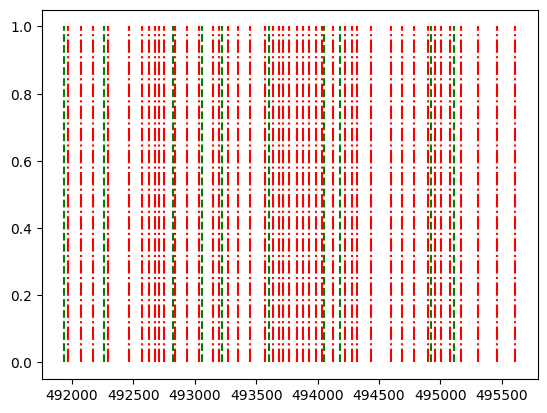

In [24]:
plt.figure()
start = 1200
end = 1210
plt.vlines(events[start:end,0],ymin=0,ymax=1,color='green',linestyle='dashed')
plt.vlines([i for i in events_ph[:,0] if i < events[end,0] and i > events[start,0]],ymin=0,ymax=1,color='red',linestyle='dashdot')
plt.savefig('./test.png')

In [25]:
epochs = mne.Epochs(
        raw, events_ph, metadata=phonemes, tmin=-0.1, tmax=0.5, decim=10, baseline=(-0.1, 0.0)
    )

data = epochs.get_data()
epochs.load_data()

# Scaling the data
n_words, n_chans, n_times = data.shape
vec = data.transpose(0, 2, 1).reshape(-1, n_chans)
scaler = RobustScaler()
idx = np.arange(len(vec))
np.random.shuffle(idx)
vec = scaler.fit(vec[idx[:20_000]]).transform(vec)
# To try: sigmas = 7 or 15
sigma = 7
vec = np.clip(vec, -sigma, sigma)
epochs._data[:, :, :] = (
    scaler.inverse_transform(vec)
    .reshape(n_words, n_times, n_chans)
    .transpose(0, 2, 1)
)


In [26]:
epo = epochs.copy()
epochs = []
epo.metadata["label"] = f"run_{run_id}"
epochs.append(epo)


In [27]:
for epo in epochs:
    epo.info["dev_head_t"] = epochs[0].info["dev_head_t"]
    # epo.info['nchan'] = epochs[0].info['nchan']

#epochs = mne.concatenate_epochs(epochs)


In [28]:
epochs[0]

Number of events,6229
Events,128: 6229
Time range,-0.100 – 0.500 sec
Baseline,-0.100 – 0.000 sec


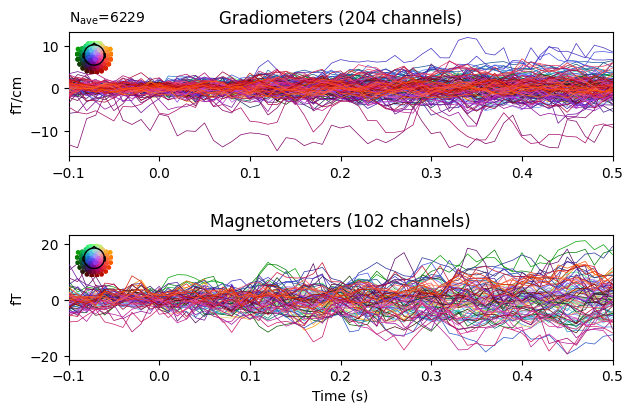

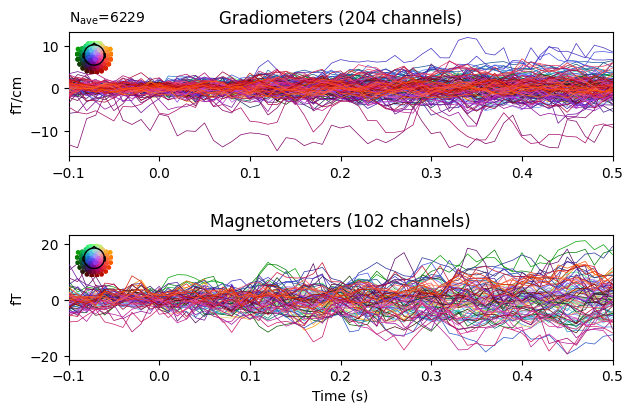

In [29]:

# Get the evoked potential averaged on all epochs for each channel
evo = epochs[0].average(method="median")
evo.plot(spatial_colors=True)


In [30]:
plt.savefig('./fig_evoked.png')

<Figure size 640x480 with 0 Axes>

.............................................................

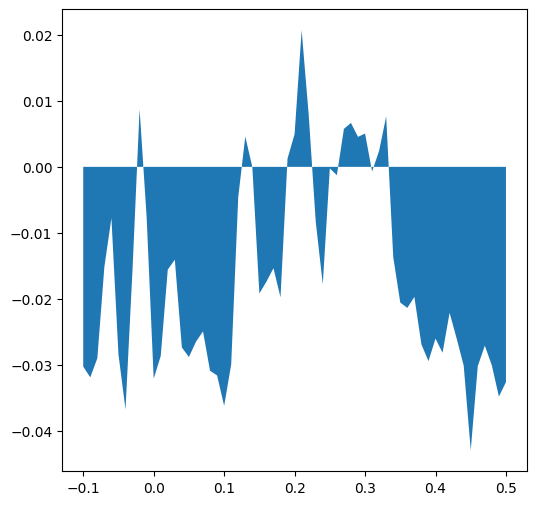

In [31]:
X = epochs[0].get_data()  # Both mag and grad
y = np.array([str(tupl).__contains__('non-voiced') for tupl in phonemes.iterrows()])
R = decod(X, y)

fig, ax = plt.subplots(1, figsize=[6, 6])
dec = plt.fill_between(epochs[0].times, R)

In [45]:
epo.metadata

,onset,duration,trial_type,label
0,3.050000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
1,3.145000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
2,3.215000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
3,3.245000,0.02,"{'kind': 'phoneme', 'voice': 'voiced'}",run_01
4,3.280000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
...,...,...,...,...
6224,610.295000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
6225,610.345000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
6226,610.380000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01
6227,610.415000,0.02,"{'kind': 'phoneme', 'voice': 'non-voiced'}",run_01


In [32]:
plt.savefig('./fig_decode.png')

<Figure size 640x480 with 0 Axes>